In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import linregress
from matplotlib.patches import Rectangle
from plot import load_logs, plot_runs, add_values_from_normal_runs, PV_MAP
# refresh files

%load_ext autoreload
%autoreload 2

In [2]:
BASE_DIR = "/home/getznerj/Documents/Thesis/Thesis Final Experiments"

In [3]:
def plot_data(data, log_dir, secondary_color_at=None, secondary_color_legend_text="", override_insignificance=False):
    # split data into two dicts, one where keys contain nonDP and the others
    data_nonDP = {key: dataset for key, dataset in data.items() if "noDP" in key}
    data_DP = {key: dataset for key, dataset in data.items() if "noDP" not in key}
    # order dicts by key
    data_nonDP = {k: data_nonDP[k] for k in sorted(data_nonDP)}
    data_DP = {k: data_DP[k] for k in sorted(data_DP)}
    for data_dict in [data_nonDP,data_DP]:
        for idx, (df_name, df) in enumerate(data_dict.items()):
            fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
            fontSize = 11
            rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': fontSize, 'axes.titlesize': fontSize, 'font.size': fontSize, 'legend.fontsize': fontSize*0.7}
            plt.rcParams.update(rc)
            pv = "age" if "age" in df_name else "sex"
            metrics = [col for col in df.columns if "subgroupAUROC" in col]
            df = df[["protected_attr", "protected_attr_percent", "seed"] + metrics]
            df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
            protected_attrs_to_plot = [np.round(k,2) for k in np.arange(0, 1.1, 0.1)] + [0.25,0.75]
            df = df.loc[df["protected_attr_percent"].isin(protected_attrs_to_plot)]
            metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
            g = plot_runs(df, metrics, pv, secondary_color_at=secondary_color_at, secondary_color_legend_text=secondary_color_legend_text, override_insignificance=override_insignificance, ax=axes, font_size=fontSize)
            # remove x label if idx == 0
            plt.tight_layout()
            plt.show()
            fig.savefig(f"../plots/{log_dir}/{pv}_{'DP' if not 'noDP' in df_name else 'no-DP'}.png", bbox_inches="tight")

In [4]:
def compute_performance_gaps(data):
    for df_name, df in data.items():
        metrics = [col for col in df.columns if "subgroupAUROC" in col]
        pv = "age" if "age" in df_name else "sex"
        dp = False if "noDP" in df_name else True
        df_temp = df[["protected_attr", "protected_attr_percent"] + [col for col in df.columns if "subgroupAUROC" in col]]
        # compute mean performance at each protected attribute percentage
        df_temp = df_temp.groupby(["protected_attr","protected_attr_percent"]).mean().reset_index()
        df_temp = df_temp.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
        df_temp["performance_gap"] = abs(df_temp[PV_MAP[pv][1]] - df_temp[PV_MAP[pv][0]])*100
        # print(f"{'DP' if dp else 'No-DP'}: Mean performance gap for {pv}: {df_temp['performance_gap'].mean()}")
        print(f"{'DP' if dp else 'No-DP'} with {pv}:")
        print("worst case performance gap: ", df_temp["performance_gap"].max())
        print("mean performance gap: ", df_temp["performance_gap"].mean())


# Baseline

In [ ]:
log_dir = os.path.join(BASE_DIR, "baseline")
data = load_logs(log_dir = log_dir)

In [ ]:
plot_data(data, "baseline")

In [ ]:
compute_performance_gaps(data)

# Up-Sampling

In [ ]:
log_dir = os.path.join(BASE_DIR, "upsampling")
data = load_logs(log_dir = log_dir)
data = add_values_from_normal_runs(BASE_DIR, data, 0.5)

In [ ]:
plot_data(data, log_dir="upsampling", secondary_color_at=0.5, secondary_color_legend_text="balanced - no upsampling")

In [ ]:
compute_performance_gaps(data)

# Loss Weighting

In [19]:
log_dir = os.path.join(BASE_DIR, "loss_weighing")
data = load_logs(log_dir = log_dir)

In [20]:
def get_values_from_normal_runs(data_outer, split):
    data_normal = load_logs(log_dir = os.path.join(BASE_DIR, "baseline"))
    new_rows = {}
    for key, df_normal in data_normal.items():
        pv = "age" if "age" in key else "sex"
        dp = False if "noDP" in key else True
        corresponding_outer_keys = [k for k in data_outer.keys() if pv in k and ((not dp) == ("noDP" in k))]
        if corresponding_outer_keys == []:
            continue
        else:
            corresponding_outer_key = corresponding_outer_keys[0]
        rows = df_normal[df_normal["protected_attr_percent"] == split]
        new_rows[corresponding_outer_key] = rows
    return new_rows

In [21]:
data_weight_1 = get_values_from_normal_runs(data, 0.5)
for key, dataset in data_weight_1.items():
    dataset["weight"] = 1
    data[key] = pd.concat([data[key], dataset])

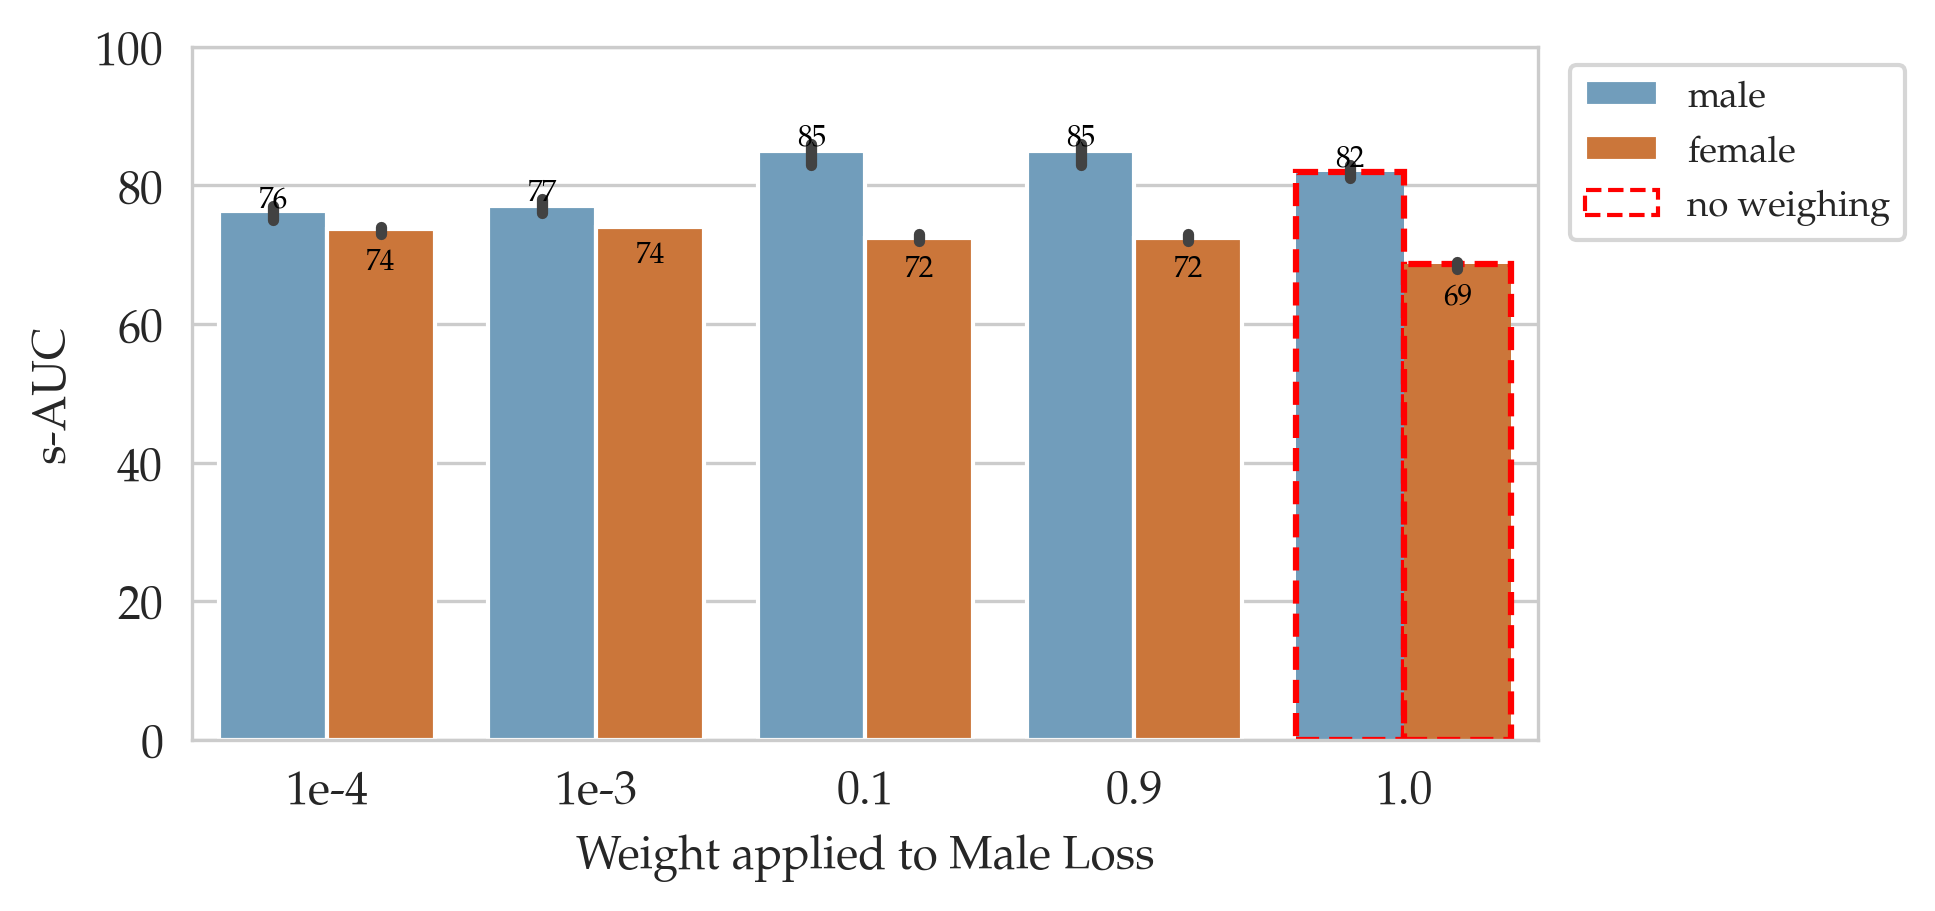

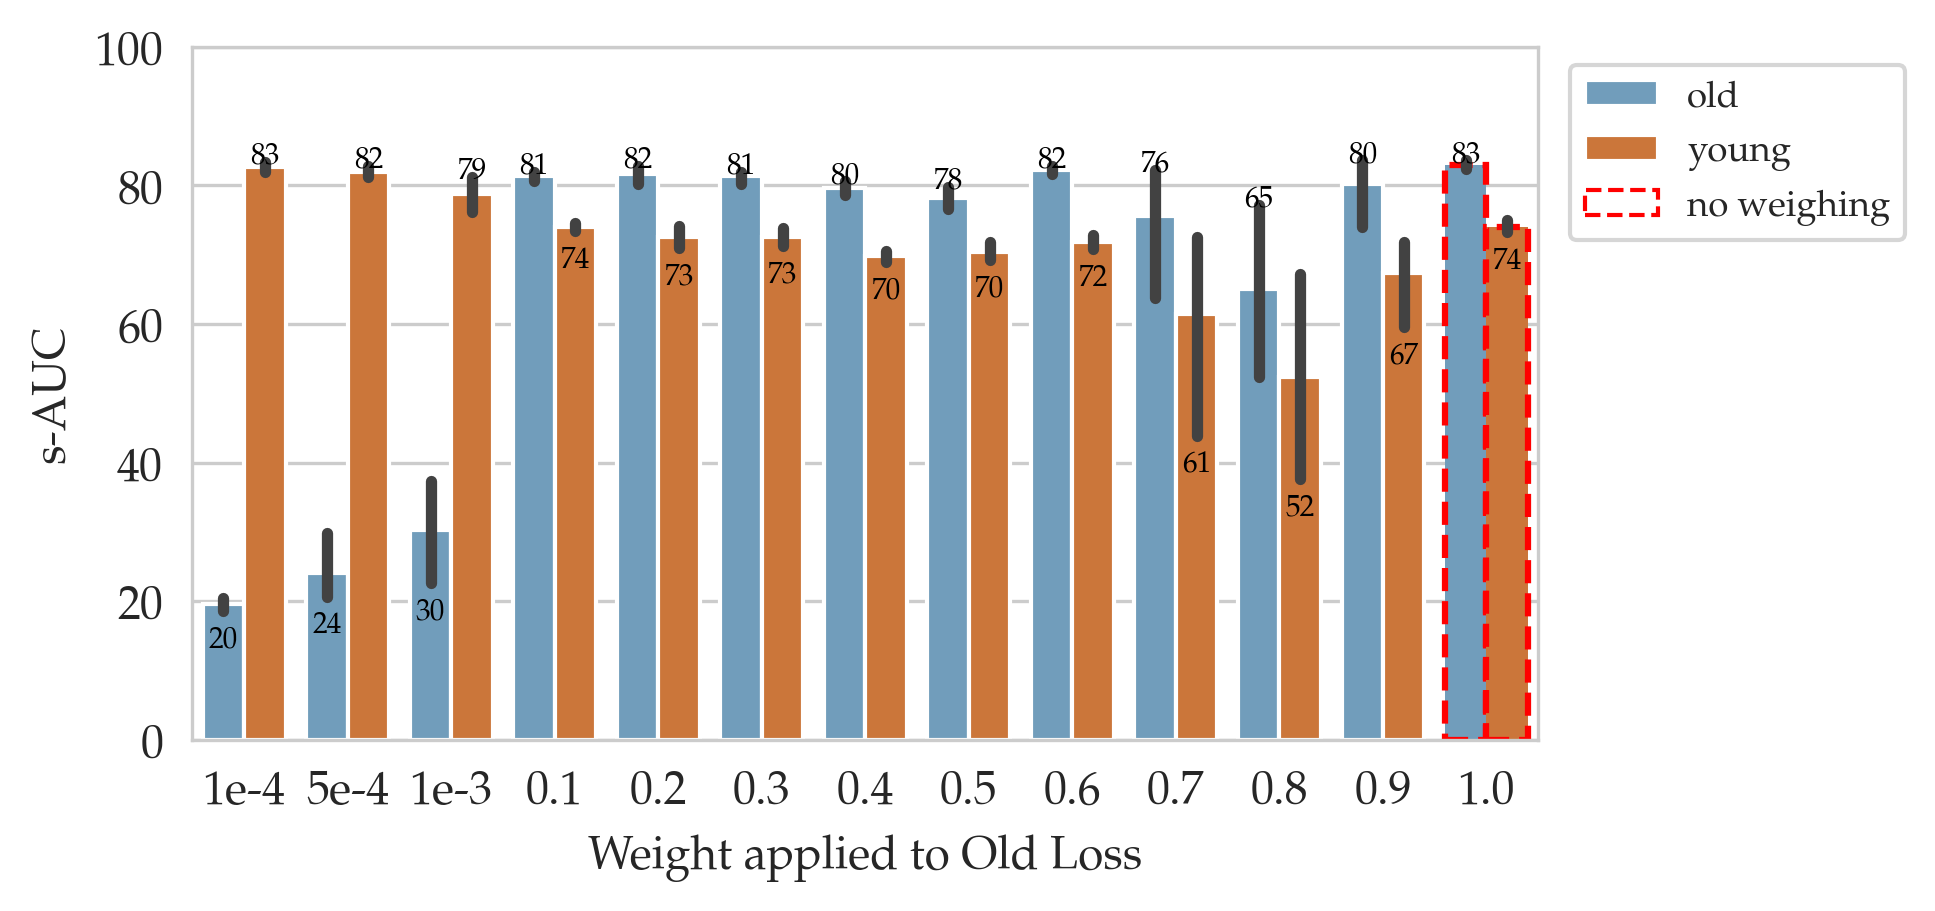

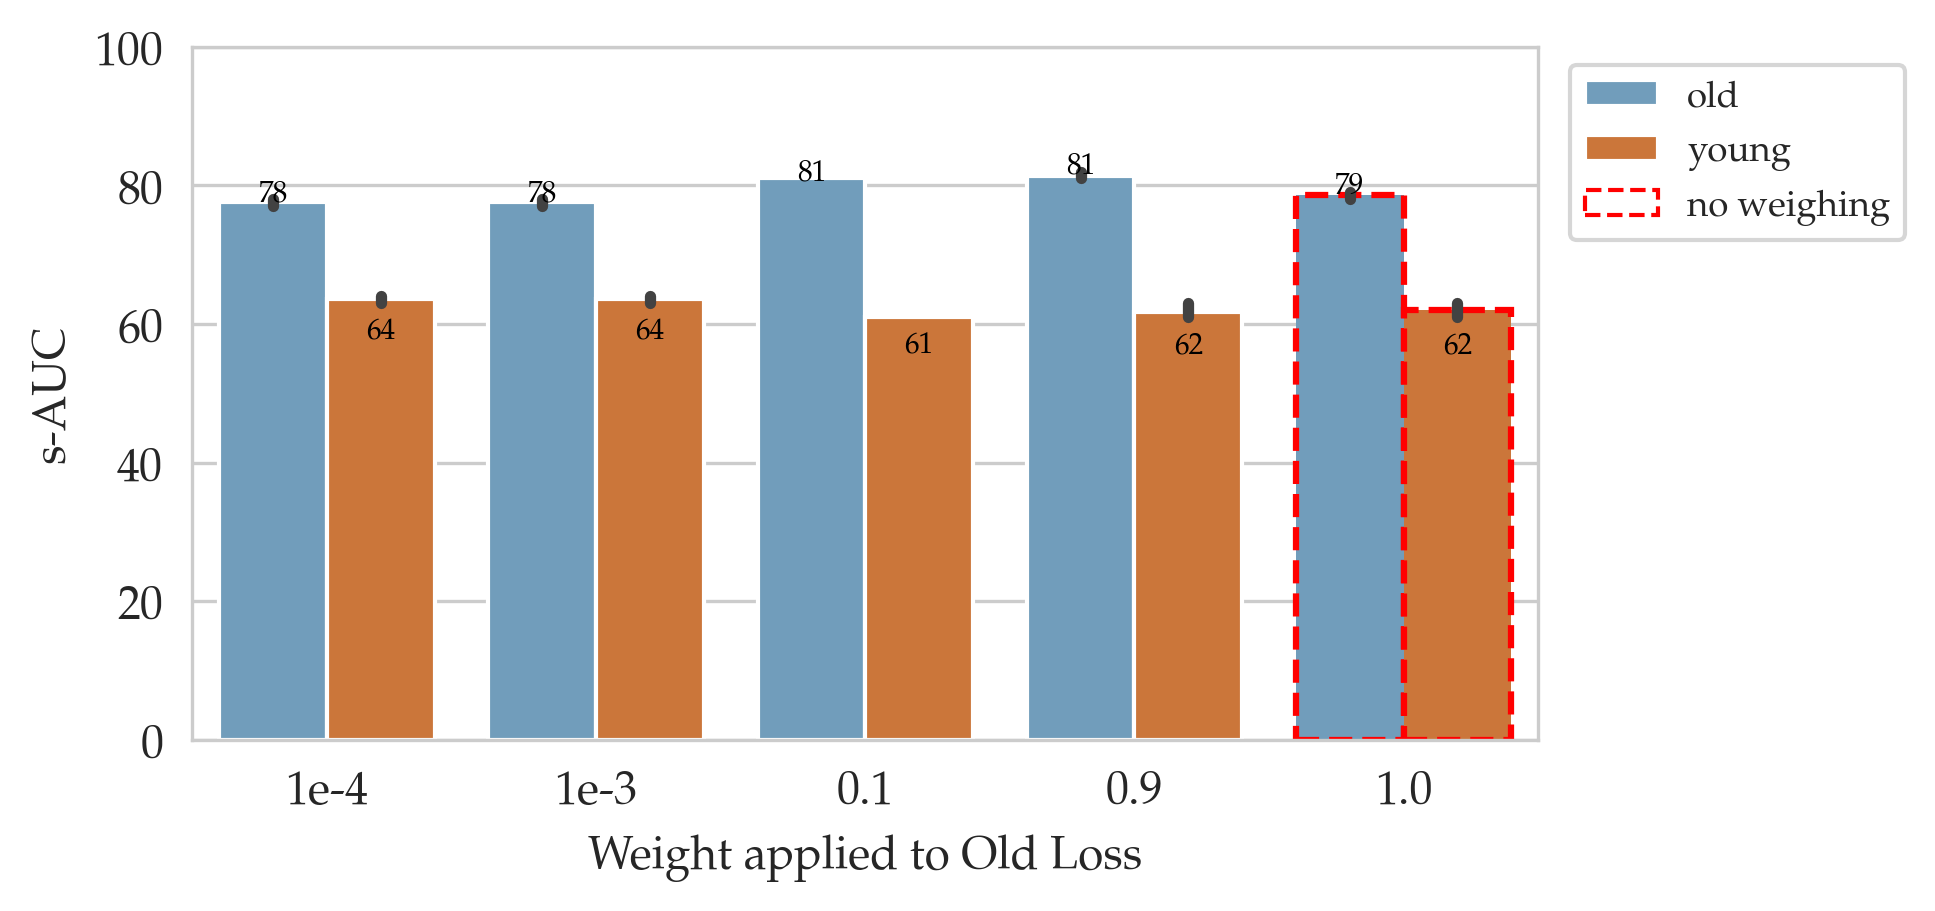

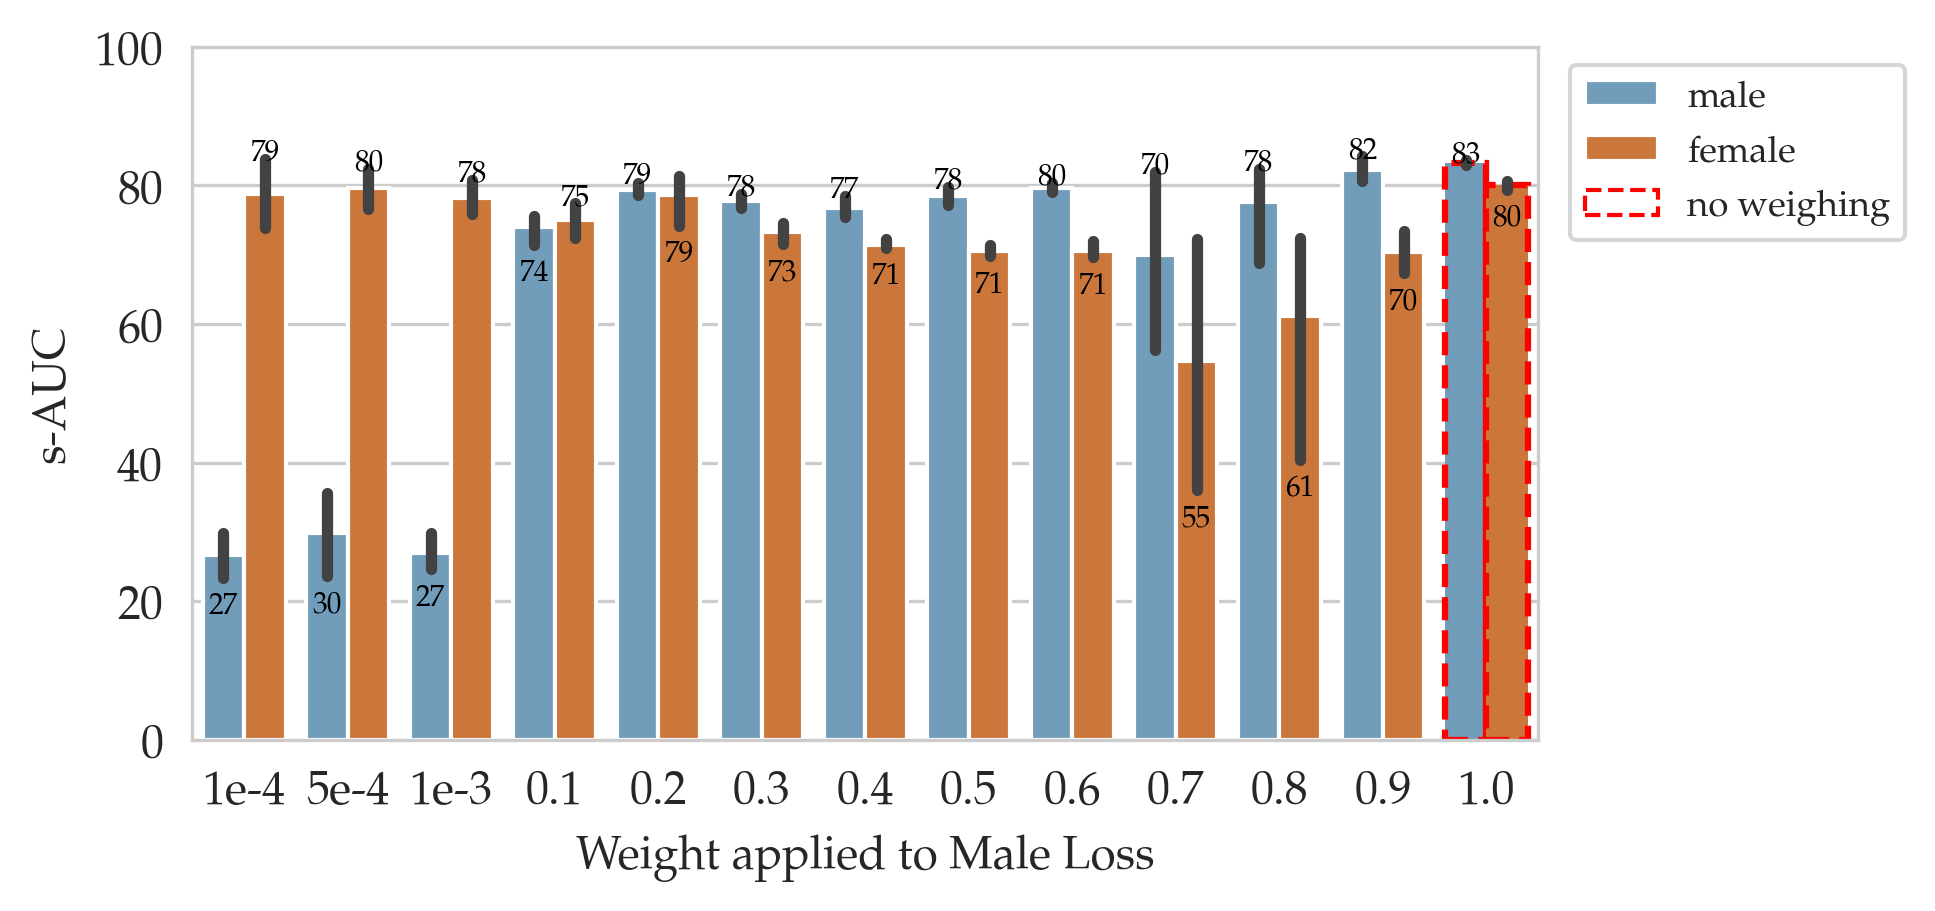

In [61]:
for key, dataset in data.items():
    fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
    font_size = 11
    rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': font_size, 'axes.titlesize': font_size, 'font.size': font_size, 'legend.fontsize': font_size*0.8}
    plt.rcParams.update(rc)
    dataset = dataset.loc[dataset["protected_attr_percent"] == 0.5]
    pv = "age" if "age" in key else "sex"
    metrics = [col for col in dataset.columns if "subgroupAUROC" in col]
    df = dataset[["protected_attr", "protected_attr_percent", "seed", "weight"] + metrics]
    # rename metrics
    df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
    metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
    axes = plot_runs(
        df,
        metrics,
        pv,
        secondary_color_at=1.0,
        secondary_color_legend_text="no weighing",
        x_var="weight",
        regress=False,
        ax=axes,
        font_size=font_size*0.8
    )
    fig.savefig(f"../plots/loss_weighing/{pv}_{'DP' if not 'noDP' in key else 'no-DP'}.png", bbox_inches="tight")

# Fine-Tuning

In [ ]:
data = load_logs(log_dir = "../logs_final/fine_tuning", fine_tuning=True)

In [ ]:
plot_data(data, override_insignificance=True)